<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install detecto

In [2]:
!pip install torch==1.4

     |████████████████████████████████| 753.4MB 20kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [3]:
!pip install torchvision==0.5.0

     |████████████████████████████████| 4.0MB 7.8MB/s 
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
from detecto import core, utils, visualize
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import numpy as np
import tensorflow as tf
import glob

import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image

import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

In [5]:
print(torch.cuda.is_available())

True


In [6]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Object detection - directory')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
!ls

 barchart.jpg		 images			 test.csv       val.csv
 bar-horizontal_1.png	 pred.txt		 test_labels    val_labels
'Copy of 2138674.jpeg'	 sample-bar-chart.jpg	 train.csv
 food-pie-chart.jpg	 smooth_line_chart.png	 train_labels


In [ ]:
#utils.xml_to_csv('train_labels', 'train.csv')
#utils.xml_to_csv('val_labels', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,bar98.jpg,1042,422,title,533,14,935,93
1,bar98.jpg,1042,422,legend,115,383,590,419
2,bar98.jpg,1042,422,axis label,8,24,29,99
3,bar81.jpg,481,289,title,221,18,328,46
4,bar91.jpg,448,224,legend,350,56,432,100
...,...,...,...,...,...,...,...,...
283,radar89.JPEG,602,391,title,61,15,577,33
284,radar89.JPEG,602,391,legend,28,46,158,132
285,scatter83.jpg,336,232,axis label,9,98,23,165
286,scatter83.jpg,336,232,axis label,145,206,203,225


In [ ]:
#Gaussian noise function inspired from https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html
class Noise():
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, img):
        self.stddev = np.random.exponential(self.stddev)
        noise = torch.zeros_like(img).normal_(self.mean, self.stddev)
        return img.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},stddev={self.stddev})"
        return repr

In [ ]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    Noise(mean=0.0, stddev=0.15), 
    utils.normalize_transform()
])

In [ ]:
dataset = core.Dataset('train.csv', 'images/', transform=transform_img)

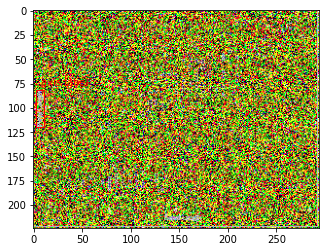

In [ ]:
from detecto.visualize import show_labeled_image

image, targets = dataset[1000]
visualize.show_labeled_image(image, targets['boxes'], targets['labels'])

In [ ]:
val_dataset = core.Dataset('val.csv', 'images/')

Epoch 1 of 5
Loss: 0.19540438143626992
Epoch 2 of 5
Loss: 0.1592806227854453
Epoch 3 of 5
Loss: 0.16032703150348324
Epoch 4 of 5
Loss: 0.152997743706995
Epoch 5 of 5
Loss: 0.15571472130250186


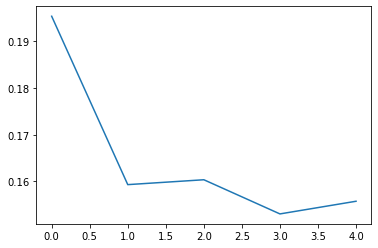

In [ ]:
model = core.Model(['title', 'legend', 'axis label'])

loader = core.DataLoader(dataset=dataset, shuffle=True)
losses = model.fit(loader, val_dataset, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses)
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise.pth')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bar-horizontal.png to bar-horizontal.png


In [7]:
model2 = core.Model.load('/content/drive/My Drive/Colab Notebooks/Obj det model noise.pth', ['title', 'legend', 'axis label'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [8]:
images =[]
files = glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.jpg') + glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.jpeg')
for img in files:
  image2 = utils.read_image(img)
  images.append(image2)

In [9]:
print(len(images))

138


In [10]:
images3 = images[:20]
print(len(images3))

20


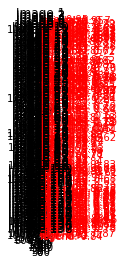

In [ ]:
visualize.plot_prediction_grid(model2, images, score_filter=0.6)

In [65]:
l =[]
b=[]
s=[]

pred2 = model2.predict(images)
for j in range(0,100,1):
  labels2, boxes2, scores2 = pred2[j]
  l.append(labels2)
  b.append(boxes2)
  s.append(scores2)

RuntimeError: ignored

In [53]:
voc_labels = ('title', 'legend', 'axis label')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}

In [54]:
print(label_map)

{'title': 1, 'legend': 2, 'axis label': 3}


In [55]:
print(l)

[['title', 'legend', 'axis label', 'legend', 'legend', 'legend', 'legend', 'legend', 'legend'], ['title', 'legend', 'axis label', 'title', 'title'], ['axis label', 'axis label', 'title', 'legend', 'axis label', 'legend', 'legend', 'legend', 'axis label', 'legend'], ['title', 'legend', 'legend', 'axis label', 'legend', 'legend', 'legend', 'legend'], ['title', 'legend', 'axis label', 'legend']]


In [56]:
for x in l:
  for y in range(len(x)):
    x[y] = int(label_map[x[y]])

In [57]:
print(l)

[[1, 2, 3, 2, 2, 2, 2, 2, 2], [1, 2, 3, 1, 1], [3, 3, 1, 2, 3, 2, 2, 2, 3, 2], [1, 2, 2, 3, 2, 2, 2, 2], [1, 2, 3, 2]]


In [58]:
x1=[]
for x in range(len(l)):
  l[x] = np.asarray(l[x])

In [59]:
print(l)

[array([1, 2, 3, 2, 2, 2, 2, 2, 2]), array([1, 2, 3, 1, 1]), array([3, 3, 1, 2, 3, 2, 2, 2, 3, 2]), array([1, 2, 2, 3, 2, 2, 2, 2]), array([1, 2, 3, 2])]


In [62]:
for x in range(len(l)):
  l[x] = torch.from_numpy(l[x])

In [63]:
print(l)

[tensor([1, 2, 3, 2, 2, 2, 2, 2, 2]), tensor([1, 2, 3, 1, 1]), tensor([3, 3, 1, 2, 3, 2, 2, 2, 3, 2]), tensor([1, 2, 2, 3, 2, 2, 2, 2]), tensor([1, 2, 3, 2])]


In [17]:
print(b)

[tensor([[ 11.9657,   2.6696, 123.0901,  15.1436],
        [201.8112,  68.6660, 234.3101, 101.1373],
        [  0.0000, 157.0532, 253.3824, 180.4791],
        [230.9966, 182.0004, 255.4770, 193.7086],
        [  8.1820, 160.2499, 172.6293, 177.9526],
        [136.0115, 157.4855, 252.6039, 179.0325],
        [  4.3026, 161.1208,  91.2394, 176.6686],
        [197.7411,  40.3700, 243.4712, 102.8544],
        [229.6016, 180.9053, 258.6237, 194.0000],
        [  5.8235, 166.5181, 136.6268, 177.1637]]), tensor([[ 43.9598,   7.1514, 241.8724,  21.1111],
        [112.4072, 166.1211, 168.7672, 179.8185],
        [110.8071, 167.2242, 168.0190, 179.1307],
        [110.6845,   8.5295, 238.2871,  19.0059],
        [ 37.4838,   8.7672, 161.2269,  19.1038]]), tensor([[   6.1892,  382.3308,   34.8848,  474.5214],
        [ 537.3411,  731.5026,  683.1327,  767.0477],
        [  13.4814,   11.9537,  328.0172,   53.8548],
        [ 324.3784,  107.5679, 1054.6173,  144.4665],
        [ 920.6741,  108.2408

In [ ]:
for sublist, new_value in zip(M, new_column): 
    sublist[c_idx] = new_value 

In [ ]:
np.asarray(labels)

array(['legend', 'title', 'axis label'], dtype='<U10')

In [ ]:
print(boxes)

tensor([[355.5713, 117.1340, 419.1940, 173.8291],
        [ 99.6244,   6.6841, 356.5358,  29.8070],
        [ 11.5329, 120.3731,  33.4410, 189.1714]])


In [ ]:
boxes.numpy()

array([[355.57132  , 117.13401  , 419.19403  , 173.82912  ],
       [ 99.62444  ,   6.6840873, 356.5358   ,  29.807003 ],
       [ 11.5329485, 120.37312  ,  33.440952 , 189.17145  ]],
      dtype=float32)

In [ ]:
print(scores)

tensor([0.5950, 0.9827, 0.6459])


In [ ]:
scores.numpy()

array([0.95547795, 0.88978213, 0.6252476 ], dtype=float32)

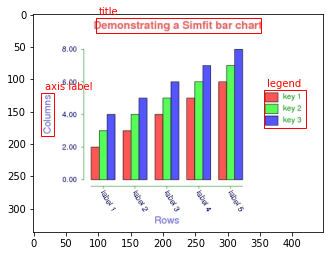

In [ ]:
visualize.show_labeled_image(image2, boxes, labels)

In [ ]:
utils.xml_to_csv('test_labels', 'test.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,scatter101.jpg,560,420,axis label,261,397,319,419
1,radar103.jpg,500,301,legend,403,143,497,185
2,scatter102.jpg,336,232,axis label,9,96,23,165
3,radar102.jpg,807,594,title,274,6,528,34
4,radar101.jpg,597,403,title,77,15,501,43
5,pie101.jpg,284,281,title,28,6,254,23
6,pie103.jpg,620,300,title,235,5,380,27
7,pie102.jpg,958,621,legend,777,287,895,389
8,pareto103.jpg,638,479,axis label,6,173,31,272
9,pareto102.jpg,640,437,axis label,306,408,359,429


In [ ]:
test_dataset = core.Dataset('test.csv', 'test_labels/')

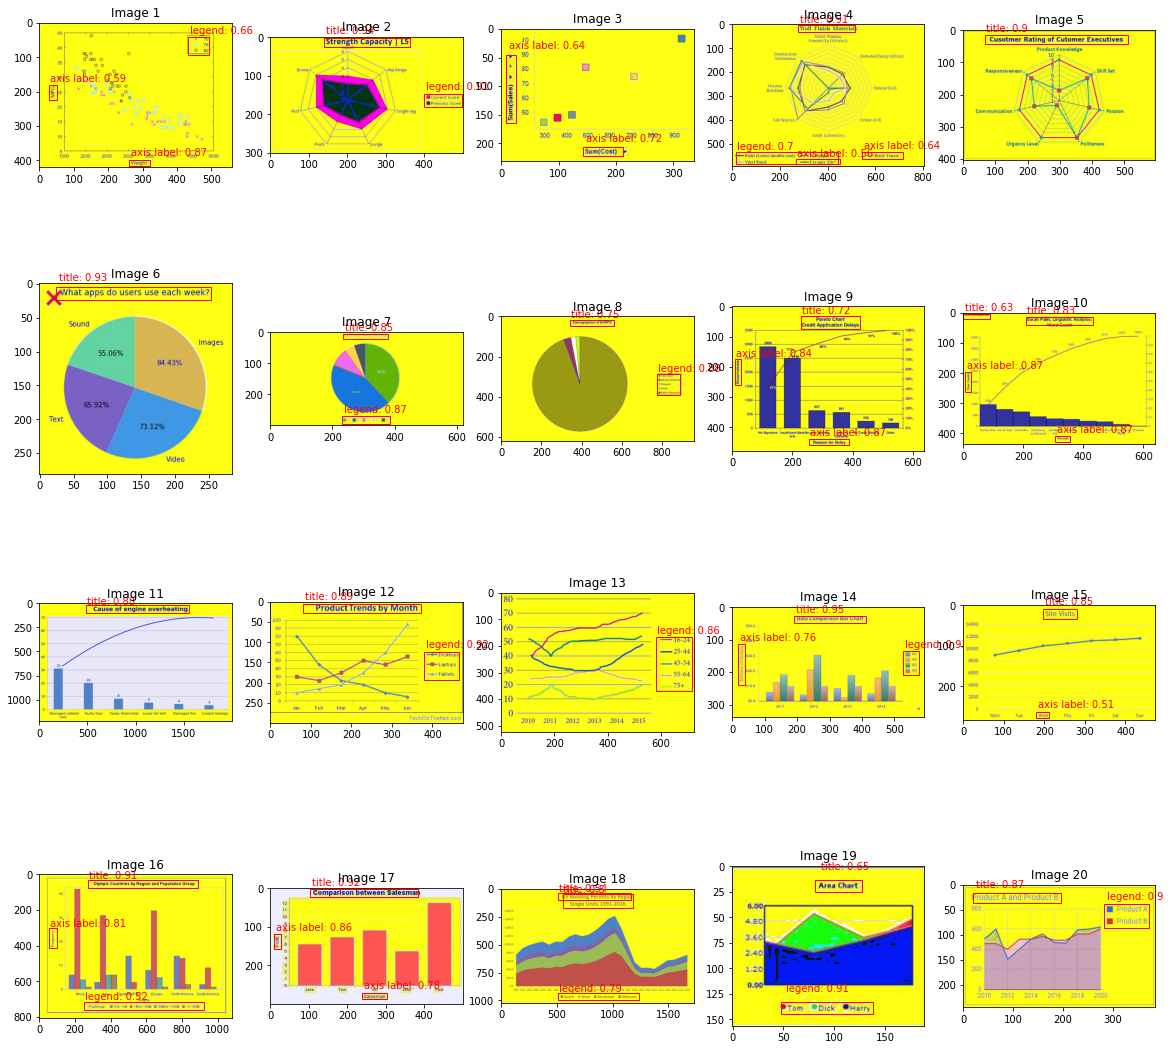

In [ ]:
img =[]
for i in range(0,20,1):
  img_temp, _ = test_dataset[i]
  img.append(img_temp)

visualize.plot_prediction_grid(model2, img, dim=(4,5), figsize= (20,20), score_filter=0.4)

In [ ]:
for i in range(0,2,1):
  pred = model2.predict_top(img[i])
  labels2, boxes2, scores2 = pred
  l2 = np.asarray(labels2)
  b2 = boxes2.numpy()
  s2 = scores2.numpy()
  np.savetxt('pred.txt', b2, delimiter=",", newline='\n')

In [ ]:
pr = pd.read_csv('pred.txt')
pr

,3.996280212402343750e+02,1.466677398681640625e+02,4.986806335449218750e+02,1.822491760253906250e+02
0,139.105515,1.497344,363.031464,23.941069


In [ ]:
l =[]
b=[]
s=[]

pred2 = model2.predict_top()
for j in range(0,20,1):
  labels2, boxes2, scores2 = pred[j]
  l.append(labels2)
  b.append(boxes2)
  s.append(scores2)
  #np.savetxt('pred.txt', b, delimiter=",", newline='\n')

ValueError: ignored

In [ ]:
print(l)

[['axis label', 'legend'], ['legend', 'title'], ['axis label', 'legend'], ['legend', 'title', 'axis label'], ['title'], ['axis label', 'title'], ['legend', 'title'], ['legend', 'title', 'axis label'], ['axis label', 'title'], ['axis label', 'title'], ['title'], ['legend', 'title', 'axis label'], ['legend', 'axis label'], ['legend', 'title', 'axis label'], ['axis label', 'title'], ['axis label', 'title', 'legend'], ['axis label', 'title'], ['legend', 'title', 'axis label'], ['legend', 'title', 'axis label'], ['legend', 'title']]


In [ ]:
print (s)

[tensor([0.8686, 0.6591]), tensor([0.9146, 0.9417]), tensor([0.7216, 0.2141]), tensor([0.6969, 0.9139, 0.6444]), tensor([0.8989]), tensor([0.3114, 0.9270]), tensor([0.9241, 0.8550]), tensor([0.8844, 0.7501, 0.1111]), tensor([0.8714, 0.7165]), tensor([0.8740, 0.8310]), tensor([0.8834]), tensor([0.9260, 0.8865, 0.3856]), tensor([0.8611, 0.0748]), tensor([0.9264, 0.9465, 0.7596]), tensor([0.5127, 0.8529]), tensor([0.8105, 0.9134, 0.5175]), tensor([0.8612, 0.9198]), tensor([0.7927, 0.5378, 0.0568]), tensor([0.9141, 0.6490, 0.3161]), tensor([0.8971, 0.8726])]


In [ ]:
print(b)

[tensor([[260.2150, 397.2323, 321.2170, 415.8729],
        [432.5749,  40.5915, 493.8985,  91.8447]]), tensor([[399.6280, 146.6677, 498.6806, 182.2492],
        [139.1057,   1.4974, 363.0314,  23.9411]]), tensor([[141.9624, 206.8696, 211.7387, 222.3047],
        [304.2411,   8.4205, 326.0742,  30.5933]]), tensor([[ 14.2189, 533.8637, 443.5025, 585.0967],
        [277.9332,   3.9593, 516.2253,  34.1177],
        [546.6663, 533.4201, 714.5917, 564.4732]]), tensor([[ 67.0668,  15.1731, 511.7279,  41.1543]]), tensor([[233.0123,  79.0312, 274.6791,  95.5292],
        [ 23.9770,   4.8766, 253.1781,  23.7685]]), tensor([[231.5911, 269.5627, 387.8220, 297.0842],
        [233.9373,   4.3456, 377.7939,  22.7736]]), tensor([[774.9881, 284.6110, 892.5137, 392.2986],
        [340.1855,  15.6993, 559.4952,  48.1018],
        [351.2318,  17.4908, 545.4537,  42.5073]]), tensor([[253.9629, 438.7404, 386.2471, 460.0131],
        [227.7906,  32.3211, 424.7520,  75.9304]]), tensor([[  7.1466, 196.0941,  2

In [ ]:

for i in range(len(b)):
  for j in range
  b[i].numpy()

In [ ]:
print(b)

[tensor([[260.2150, 397.2323, 321.2170, 415.8729],
        [432.5749,  40.5915, 493.8985,  91.8447]]), tensor([[399.6280, 146.6677, 498.6806, 182.2492],
        [139.1057,   1.4974, 363.0314,  23.9411]]), tensor([[141.9624, 206.8696, 211.7387, 222.3047],
        [304.2411,   8.4205, 326.0742,  30.5933]]), tensor([[ 14.2189, 533.8637, 443.5025, 585.0967],
        [277.9332,   3.9593, 516.2253,  34.1177],
        [546.6663, 533.4201, 714.5917, 564.4732]]), tensor([[ 67.0668,  15.1731, 511.7279,  41.1543]]), tensor([[233.0123,  79.0312, 274.6791,  95.5292],
        [ 23.9770,   4.8766, 253.1781,  23.7685]]), tensor([[231.5911, 269.5627, 387.8220, 297.0842],
        [233.9373,   4.3456, 377.7939,  22.7736]]), tensor([[774.9881, 284.6110, 892.5137, 392.2986],
        [340.1855,  15.6993, 559.4952,  48.1018],
        [351.2318,  17.4908, 545.4537,  42.5073]]), tensor([[253.9629, 438.7404, 386.2471, 460.0131],
        [227.7906,  32.3211, 424.7520,  75.9304]]), tensor([[  7.1466, 196.0941,  2

In [ ]:
def align_coordinates(boxes):
    """Align coordinates (x1,y1) < (x2,y2) to work with torchvision `box_iou` op
    Arguments:
        boxes (Tensor[N,4])
    
    Returns:
        boxes (Tensor[N,4]): aligned box coordinates
    """
    x1y1 = torch.min(boxes[:,:2,],boxes[:, 2:])
    x2y2 = torch.max(boxes[:,:2,],boxes[:, 2:])
    boxes = torch.cat([x1y1,x2y2],dim=1)
    return boxes

In [ ]:
align_coordinates(boxes2)

tensor([[283.5508,  38.8913, 372.7875,  86.9234],
        [ 20.5188,  15.4589, 195.7647,  36.7844]])

In [ ]:
def calculate_iou(gt, pr):
  gt = align_coordinates(gt)
    pr = align_coordinates(pr)
    
    return box_iou(gt,pr)

In [ ]:
df = pd.read_csv('test.csv')

In [ ]:
df.set_index('filename')
print(df)

          filename  width  height       class  xmin  ymin  xmax  ymax
0   scatter101.jpg    560     420  axis label   261   397   319   419
1     radar103.jpg    500     301      legend   403   143   497   185
2   scatter102.jpg    336     232  axis label     9    96    23   165
3     radar102.jpg    807     594       title   274     6   528    34
4     radar101.jpg    597     403       title    77    15   501    43
5       pie101.jpg    284     281       title    28     6   254    23
6       pie103.jpg    620     300       title   235     5   380    27
7       pie102.jpg    958     621      legend   777   287   895   389
8    pareto103.jpg    638     479  axis label     6   173    31   272
9    pareto102.jpg    640     437  axis label   306   408   359   429
10   pareto101.jpg   2000    1225       title   534    23  1548   112
11     line103.jpg    475     300       title   108     6   367    37
12     line102.jpg    723     524      legend   585   161   715   367
13      bar103.jpg  

In [ ]:
gt = df.reset_index()[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

In [ ]:
from torch import tensor
gt2 = tensor(gt)

ValueError: ignored

In [ ]:
print(gt2)

tensor([[ 534,   23, 1548,  112],
        [ 108,    6,  367,   37],
        [ 379,  122,  469,  193],
        [ 585,  161,  715,  367],
        [ 195,    9,  281,   34],
        [ 191,   25,  413,   56],
        [  17,  114,   40,  238],
        [ 528,  136,  572,  214],
        [ 107,    5,  393,   27],
        [   8,  123,   30,  162],
        [ 236,  271,  305,  290],
        [ 300,   36,  876,   75],
        [ 271,  729,  908,  752],
        [  56,  306,   95,  416],
        [ 550,  689,  629,  722],
        [ 526,   33, 1211,  168],
        [ 501,  936, 1222,  992],
        [  82,   12,  126,   26],
        [  44,  132,  139,  147],
        [  15,   16,  193,   38],
        [ 283,   39,  372,   86],
        [   9,   96,   23,  165],
        [ 141,  207,  206,  223],
        [ 141,    3,  365,   25],
        [ 403,  143,  497,  185],
        [ 431,   40,  494,   93],
        [  25,  178,   51,  225],
        [ 261,  397,  319,  419],
        [ 274,    6,  528,   34],
        [   9,

In [18]:
df = pd.read_csv('val.csv')
tmp = df.values

In [20]:
print(type(tmp))

<class 'numpy.ndarray'>


In [22]:
voc_labels = ('title', 'legend', 'axis label')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}

In [23]:
print(label_map)

{'title': 1, 'legend': 2, 'axis label': 3}


In [47]:
def parse_annotation(annotation_path):
    folder = glob.glob(annotation_path)
    for xmL_file in folder:
      tree = ET.parse(xmL_file)
      root = tree.getroot()

      boxes = list()
      labels = list()

      for object in root.iter('object'):

        label = object.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = object.find('bndbox')
        xmin[object] = int(bbox.find('xmin').text) - 1  
        ymin = int(bbox.find('ymin').text) - 1
        xmax = int(bbox.find('xmax').text) - 1
        ymax = int(bbox.find('ymax').text) - 1

        boxes.append(torch.tensor([xmin, ymin, xmax, ymax]))
        labels.append(torch.tensor(label_map[label]))

    return boxes, labels

In [44]:
boxes, labels = parse_annotation('/content/drive/My Drive/Colab Notebooks/Object detection - directory/val_labels/*.xml')

In [45]:
print(boxes)

[tensor([395, 100, 470, 190])]


In [31]:
print(labels)

[2, 3]


In [ ]:
data = dict()
for x, sublist in enumerate(my_list):
    data[x] = option2 = []
    for i in sublist:
        c = mb.BS([120, i, 1, 20 ], 10)
        option2.append(c.callPrice)